# Model Benchmarking and Selection
This notebook benchmarks multiple ML and DL models on a randomly sampled subset of the dataset. It evaluates models using metrics such as accuracy, recall, precision, F1 score, MCC, MSE, RMSE, and R2, and visualizes confusion matrices. The best model is selected based on these metrics.

In [22]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score, confusion_matrix)

## Load Dataset
Load the main dataset for benchmarking.

In [23]:
# Load the benchmark dataset
dataset_path = 'DATASET_BENCHMARK_SAMPLE.csv'
sample_df = pd.read_csv(dataset_path)
print(f"Benchmark dataset shape: {sample_df.shape}")
print(f"Label distribution: {sample_df['Label'].value_counts()}")
sample_df.head()

Benchmark dataset shape: (4314, 2)
Label distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64


,Sentiment,Label
0,siguruwun makapag tau oryentasyon miyembro gag...,neutral
1,school paryu iskwila grade,neutral
2,tandaan pagkopya parirala importante tandaan s...,neutral
3,kanakong rurugan,neutral
4,importante maintindiyan maray binasa itinau,neutral


## Load Models from Folder
Load all ML and DL models and their associated vectorizers/tokenizers for benchmarking.

In [24]:
# Helper functions to load models and vectorizers/tokenizers
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def load_joblib(path):
    return joblib.load(path)

def load_keras(path):
    from tensorflow import keras
    return keras.models.load_model(path)

ml_folder = 'ML'
dl_folder = 'DL'

ml_models = {
    'NaiveBayes': {
        'model': load_joblib(os.path.join(ml_folder, 'NaiveBayes_model.obj')),
        'vectorizer': load_joblib(os.path.join(ml_folder, 'NaiveBayes_tfidf_vectorizer.obj'))
    },
    'RandomForest': {
        'model': load_joblib(os.path.join(ml_folder, 'RandomForest_model.obj')),
        'vectorizer': load_joblib(os.path.join(ml_folder, 'RandomForest_tfidf_vectorizer.obj'))
    },
    'SVM': {
        'model': load_joblib(os.path.join(ml_folder, 'SVM_model.obj')),
        'vectorizer': load_joblib(os.path.join(ml_folder, 'SVM_tfidf_vectorizer.obj'))
    }
}

dl_models = {
    'RNN': {
        'model': load_keras(os.path.join(dl_folder, 'rnn_model.keras')),
        'tokenizer': load_pickle(os.path.join(dl_folder, 'rnn_tokenizer.obj'))
    },
    'LSTM': {
        'model': load_keras(os.path.join(dl_folder, 'lstm_model.keras')),
        'tokenizer': load_pickle(os.path.join(dl_folder, 'lstm_tokenizer.obj'))
    },
    'CNN': {
        'model': load_keras(os.path.join(dl_folder, 'cnn_model.keras')),
        'tokenizer': load_pickle(os.path.join(dl_folder, 'cnn_tokenizer.obj'))
    }
}

c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Benchmark Models on Sampled Dataset
Use each loaded model to make predictions on the sampled dataset.

In [25]:
# Prepare X and y for benchmarking
target_col = 'Label'  # Change if your target column is named differently
X_sample = sample_df.drop(columns=[target_col])
y_sample = sample_df[target_col]

# For DL models, convert text to sequences; for ML models, use TF-IDF
def prepare_dl_input(tokenizer, texts, maxlen=100):
    sequences = tokenizer.texts_to_sequences(texts)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(sequences, maxlen=maxlen)

results = {}

In [26]:
# Benchmark ML models
for name, items in ml_models.items():
    vectorizer = items['vectorizer']
    model = items['model']
    X_vec = vectorizer.transform(X_sample.squeeze().astype(str))
    y_pred = model.predict(X_vec)
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

In [27]:
# Benchmark DL models
for name, items in dl_models.items():
    tokenizer = items['tokenizer']
    model = items['model']
    X_seq = prepare_dl_input(tokenizer, X_sample.squeeze().astype(str))
    y_pred = model.predict(X_seq)
    # If output is probabilities, take argmax
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = (y_pred > 0.5).astype(int).flatten()
    results[name] = {'y_true': y_sample, 'y_pred': y_pred}

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


## Calculate Metrics: Accuracy, Recall, Precision, F1 Score, MCC, MSE, RMSE, R2
Compute all specified metrics for each model.

In [28]:
# Calculate metrics for each model
metrics = {}
for name, res in results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    
    print(f"\n=== {name} Metrics Calculation ===")
    print(f"True labels sample: {pd.Series(y_true).head()}")
    print(f"Predicted labels sample: {pd.Series(y_pred).head()}")
    print(f"True labels type: {type(y_true.iloc[0])}")
    print(f"Predicted labels type: {type(y_pred[0])}")
    
    # Use correct label mapping for each model type
    if name in ['RNN', 'LSTM', 'CNN']:  # DL models use 0, 1, 2
        label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
    else:  # ML models might use different mapping
        label_map = {'neutral': 0, 'positive': 1, 'negative': -1}
    
    # Determine if labels are strings or numbers
    if isinstance(y_true.iloc[0], str):
        # If predictions are numeric, map them back to string labels for classification metrics
        if not isinstance(y_pred[0], str):
            inv_label_map = {v: k for k, v in label_map.items()}
            y_pred_class = pd.Series(y_pred).map(inv_label_map)
        else:
            y_pred_class = pd.Series(y_pred)
        y_true_class = pd.Series(y_true)
        y_true_num = y_true_class.map(label_map)
        y_pred_num = y_pred_class.map(label_map) if isinstance(y_pred_class.iloc[0], str) else pd.Series(y_pred)
    else:
        y_true_num = pd.Series(y_true)
        y_pred_num = pd.Series(y_pred)
        y_true_class = y_true_num
        y_pred_class = y_pred_num
    
    # Filter out any NaNs that may have resulted from mapping
    mask = (~pd.Series(y_true_class).isna()) & (~pd.Series(y_pred_class).isna())
    y_true_class = pd.Series(y_true_class)[mask]
    y_pred_class = pd.Series(y_pred_class)[mask]
    y_true_num = pd.Series(y_true_num)[mask]
    y_pred_num = pd.Series(y_pred_num)[mask]
    
    print(f"Samples after cleaning: {len(y_true_class)}")
    
    metrics[name] = {
        # Classification metrics (use string labels) - converted to percentages
        'Accuracy': round(accuracy_score(y_true_class, y_pred_class) * 100, 2),
        'Recall': round(recall_score(y_true_class, y_pred_class, average='weighted', zero_division=0) * 100, 2),
        'Precision': round(precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0) * 100, 2),
        'F1 Score': round(f1_score(y_true_class, y_pred_class, average='weighted', zero_division=0) * 100, 2),
        'MCC': round(matthews_corrcoef(y_true_class, y_pred_class) * 100, 2),
        # Regression metrics (use mapped numeric labels) - rounded to 2 decimal places
        'MSE': round(mean_squared_error(y_true_num, y_pred_num), 2),
        'RMSE': round(np.sqrt(mean_squared_error(y_true_num, y_pred_num)), 2),
        'R2': round(r2_score(y_true_num, y_pred_num) * 100, 2)
    }
metrics_df = pd.DataFrame(metrics).T
metrics_df


=== NaiveBayes Metrics Calculation ===
True labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
Name: Label, dtype: object
Predicted labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
dtype: object
True labels type: <class 'str'>
Predicted labels type: <class 'numpy.str_'>
Samples after cleaning: 4314

=== RandomForest Metrics Calculation ===
True labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
Name: Label, dtype: object
Predicted labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
dtype: object
True labels type: <class 'str'>
Predicted labels type: <class 'str'>
Samples after cleaning: 4314

=== SVM Metrics Calculation ===
True labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
Name: Label, dtype: object
Predicted labels sample: 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
dtype: object
True labels type: <class 'str'>
Pr

,Accuracy,Recall,Precision,F1 Score,MCC,MSE,RMSE,R2
NaiveBayes,65.11,65.11,78.36,64.85,53.85,0.40,0.63,40.06
RandomForest,88.34,88.34,89.68,88.49,83.05,0.15,0.38,77.82
SVM,77.93,77.93,81.96,78.15,68.71,0.29,0.54,56.78
RNN,15.16,15.16,14.51,14.61,-27.71,1.94,1.39,-191.24
LSTM,12.68,12.68,12.13,12.39,-31.03,1.91,1.38,-187.03
CNN,8.28,8.28,8.38,8.32,-37.60,1.99,1.41,-198.12


## Display Confusion Matrix Heatmap
Plot a confusion matrix heatmap for each model.


=== NaiveBayes Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: neutral     2774
positive     827
negative     713
Name: count, dtype: int64
Samples after cleaning: 4314


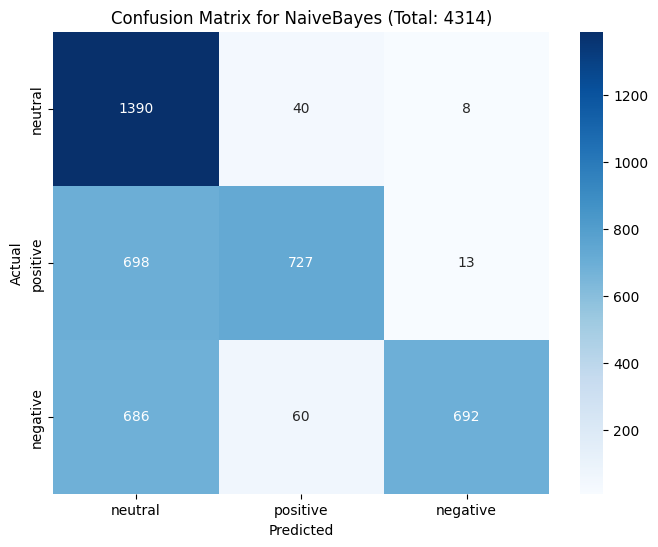

Confusion matrix total: 4314

=== RandomForest Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: neutral     1764
negative    1291
positive    1259
Name: count, dtype: int64
Samples after cleaning: 4314


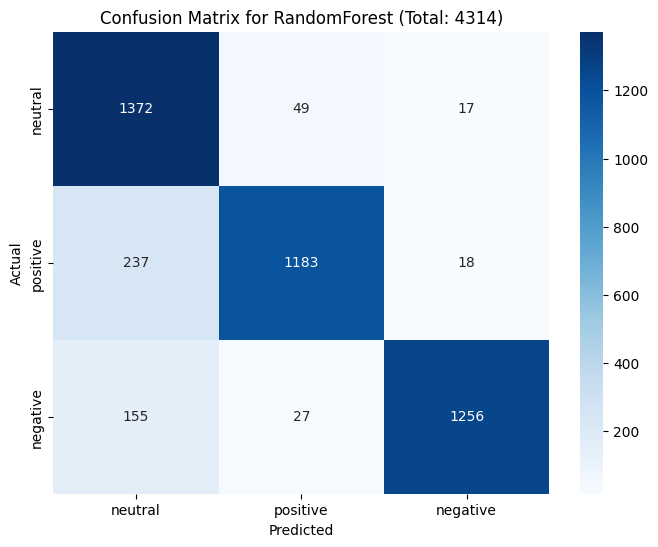

Confusion matrix total: 4314

=== SVM Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: neutral     2091
negative    1161
positive    1062
Name: count, dtype: int64
Samples after cleaning: 4314


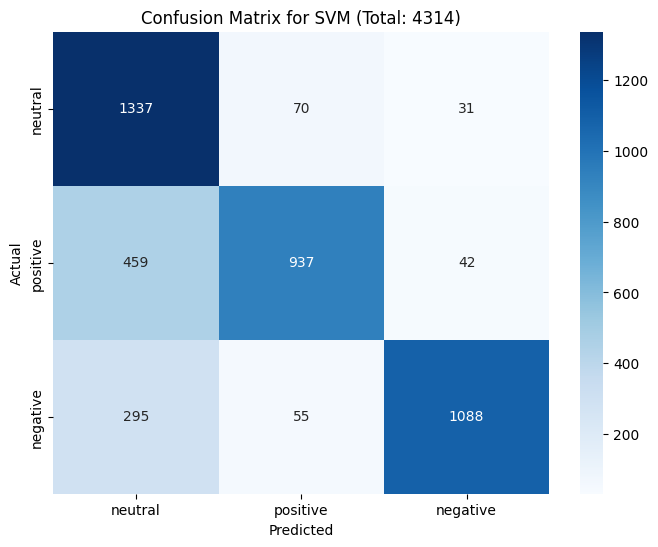

Confusion matrix total: 4314

=== RNN Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: 0    1955
1    1202
2    1157
Name: count, dtype: int64
Samples after cleaning: 4314


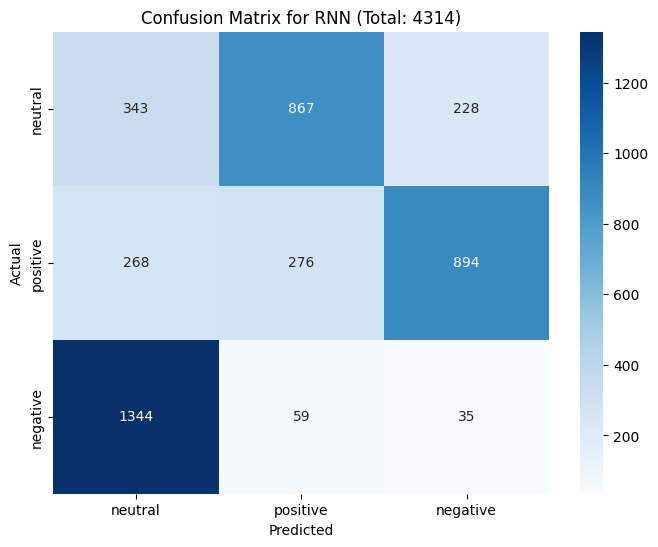

Confusion matrix total: 4314

=== LSTM Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: 1    1533
0    1507
2    1274
Name: count, dtype: int64
Samples after cleaning: 4314


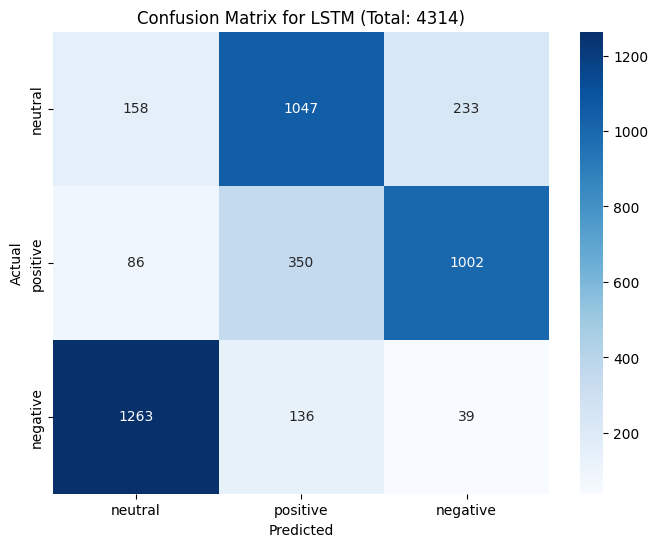

Confusion matrix total: 4314

=== CNN Model Analysis ===
Total samples: 4314
True labels distribution: Label
neutral     1438
positive    1438
negative    1438
Name: count, dtype: int64
Predicted labels distribution: 2    1519
1    1424
0    1371
Name: count, dtype: int64
Samples after cleaning: 4314


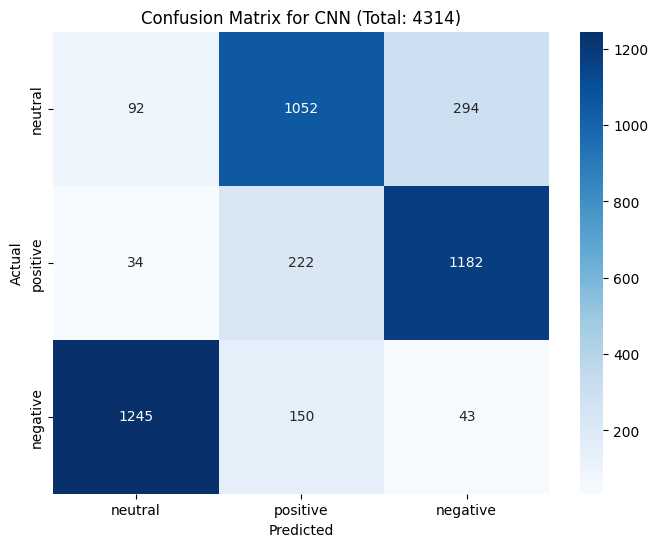

Confusion matrix total: 4314


In [29]:
# Plot confusion matrix heatmap for each model
for name, res in results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    
    print(f"\n=== {name} Model Analysis ===")
    print(f"Total samples: {len(y_true)}")
    print(f"True labels distribution: {pd.Series(y_true).value_counts()}")
    print(f"Predicted labels distribution: {pd.Series(y_pred).value_counts()}")
    
    # Use correct label mapping for DL models (0, 1, 2) vs ML models
    if name in ['RNN', 'LSTM', 'CNN']:  # DL models use 0, 1, 2
        label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
    else:  # ML models might use different mapping
        label_map = {'neutral': 0, 'positive': 1, 'negative': -1}
    
    # Convert true labels to numerical
    if isinstance(y_true.iloc[0], str):
        y_true_num = pd.Series(y_true).map(label_map)
    else:
        y_true_num = pd.Series(y_true)
    
    # Convert predicted labels to numerical  
    if isinstance(y_pred[0], str):
        y_pred_num = pd.Series(y_pred).map(label_map)
    else:
        y_pred_num = pd.Series(y_pred)
    
    # Remove any NaN values
    mask = (~y_true_num.isna()) & (~y_pred_num.isna())
    y_true_clean = y_true_num[mask]
    y_pred_clean = y_pred_num[mask]
    
    print(f"Samples after cleaning: {len(y_true_clean)}")
    
    # Create confusion matrix with explicit labels
    if name in ['RNN', 'LSTM', 'CNN']:
        cm = confusion_matrix(y_true_clean, y_pred_clean, labels=[0, 1, 2])
        tick_labels = ['neutral', 'positive', 'negative']
    else:
        cm = confusion_matrix(y_true_clean, y_pred_clean, labels=[0, 1, -1])
        tick_labels = ['neutral', 'positive', 'negative']
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=tick_labels, yticklabels=tick_labels)
    plt.title(f'Confusion Matrix for {name} (Total: {cm.sum()})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print(f"Confusion matrix total: {cm.sum()}")
    print("="*50)

## Select and Display Best Model Based on Metrics
Compare all models based on the computed metrics and display the best performing model.

In [30]:
# Select best model based on Accuracy (can change to other metric if needed)
best_model = metrics_df['Accuracy'].idxmax()
print(f"Best model based on Accuracy: {best_model}")
print(metrics_df.loc[best_model])

Best model based on Accuracy: RandomForest
Accuracy     88.34
Recall       88.34
Precision    89.68
F1 Score     88.49
MCC          83.05
MSE           0.15
RMSE          0.38
R2           77.82
Name: RandomForest, dtype: float64
